 # Required Libraries

In [94]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
import pymysql
pymysql.install_as_MySQLdb()


# Load and process data

In [95]:
# Add project path
sys.path.append(os.path.abspath(".."))

# Import database connection module
from database.db_connection import DatabaseConnector

# Handle database connection
try:
    db_connector = DatabaseConnector()
    engine = db_connector.get_engine()
except Exception as e:
    print(f"Error connecting to the database: {e}")
    sys.exit(1)  # Exit on connection failure

# Load data from the database
try:
    forecast_df = pd.read_sql("SELECT * FROM historical_forecast;", engine)
    weather_df = pd.read_sql("SELECT * FROM historical_weather;", engine)
except Exception as e:
    print(f"Error loading data from the database: {e}")
    sys.exit(1)  # Exit on data loading failure

# Convert datetime to pandas datetime
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
forecast_df['datetime'] = pd.to_datetime(forecast_df['datetime'])

# Filter Data for the 15th of Each Month

In [96]:
# Filter data for the 15th day of each month (both actual and forecast)
weather_df_15th = weather_df[weather_df['datetime'].dt.day == 15]
forecast_df_15th = forecast_df[forecast_df['datetime'].dt.day == 15]

# Merge actual weather data and forecast data on datetime
merged_df = pd.merge(weather_df_15th, forecast_df_15th, on='datetime', suffixes=('_actual', '_forecast'))


# Compute Fit Measures

In [97]:
if not merged_df.empty:
    # Define actual and predicted values for temperature
    y_actual_temp = merged_df['temperature_2m_actual']
    y_forecast_temp = merged_df['temperature_2m_forecast']

    # Compute RMSE, MAE, and R² for temperature
    rmse_temp = root_mean_squared_error(y_actual_temp, y_forecast_temp)
    mae_temp = mean_absolute_error(y_actual_temp, y_forecast_temp)
    r2_temp = r2_score(y_actual_temp, y_forecast_temp)

    # Define actual and predicted values for humidity
    y_actual_humidity = merged_df['relative_humidity_2m_actual']
    y_forecast_humidity = merged_df['relative_humidity_2m_forecast']

    # Compute RMSE, MAE, and R² for humidity
    rmse_humidity = root_mean_squared_error(y_actual_humidity, y_forecast_humidity)
    mae_humidity = mean_absolute_error(y_actual_humidity, y_forecast_humidity)
    r2_humidity = r2_score(y_actual_humidity, y_forecast_humidity)

    # Print results
    print("=== Model Fit Measures (Temperature) ===")
    print(f"RMSE (Temperature): {rmse_temp:.2f}")
    print(f"MAE (Temperature): {mae_temp:.2f}")
    print(f"R² (Temperature): {r2_temp:.2f}")

    print("\n=== Model Fit Measures (Humidity) ===")
    print(f"RMSE (Humidity): {rmse_humidity:.2f}")
    print(f"MAE (Humidity): {mae_humidity:.2f}")
    print(f"R² (Humidity): {r2_humidity:.2f}")
else:
    print("No data available for evaluation on the 15th day of each month.")


=== Model Fit Measures (Temperature) ===
RMSE (Temperature): 1.88
MAE (Temperature): 1.46
R² (Temperature): 0.94

=== Model Fit Measures (Humidity) ===
RMSE (Humidity): 11.26
MAE (Humidity): 8.58
R² (Humidity): 0.36


# ANOVA: Test for differences in temperature and relative humidity on the 15th of each month


In [98]:
# ANOVA: Test for differences in temperature and relative humidity on the 15th of each month
if len(merged_df) > 0:  # Check if there is data for the 15th of each month
    # ANOVA for actual temperature
    anova_result_temp_actual = f_oneway(
        *[merged_df[merged_df['datetime'].dt.month == month]['temperature_2m_actual'] for month in merged_df['datetime'].dt.month.unique()]
    )
    print("\n=== ANOVA (Actual Weather - Temperature) on the 15th Day ===")
    print(f"F-statistic: {anova_result_temp_actual.statistic:.2f}")
    print(f"p-value: {anova_result_temp_actual.pvalue:.4f}")

    # ANOVA for forecast temperature
    anova_result_temp_forecast = f_oneway(
        *[merged_df[merged_df['datetime'].dt.month == month]['temperature_2m_forecast'] for month in merged_df['datetime'].dt.month.unique()]
    )
    print("\n=== ANOVA (Forecast Weather - Temperature) on the 15th Day ===")
    print(f"F-statistic: {anova_result_temp_forecast.statistic:.2f}")
    print(f"p-value: {anova_result_temp_forecast.pvalue:.4f}")

    # ANOVA for actual relative humidity
    anova_result_humidity_actual = f_oneway(
        *[merged_df[merged_df['datetime'].dt.month == month]['relative_humidity_2m_actual'] for month in merged_df['datetime'].dt.month.unique()]
    )
    print("\n=== ANOVA (Actual Weather - Relative Humidity) on the 15th Day ===")
    print(f"F-statistic: {anova_result_humidity_actual.statistic:.2f}")
    print(f"p-value: {anova_result_humidity_actual.pvalue:.4f}")

    # ANOVA for forecast relative humidity
    anova_result_humidity_forecast = f_oneway(
        *[merged_df[merged_df['datetime'].dt.month == month]['relative_humidity_2m_forecast'] for month in merged_df['datetime'].dt.month.unique()]
    )
    print("\n=== ANOVA (Forecast Weather - Relative Humidity) on the 15th Day ===")
    print(f"F-statistic: {anova_result_humidity_forecast.statistic:.2f}")
    print(f"p-value: {anova_result_humidity_forecast.pvalue:.4f}")
else:
    print("\nANOVA could not be performed due to insufficient data on the 15th of each month.")



=== ANOVA (Actual Weather - Temperature) on the 15th Day ===
F-statistic: 138.47
p-value: 0.0000

=== ANOVA (Forecast Weather - Temperature) on the 15th Day ===
F-statistic: 161.93
p-value: 0.0000

=== ANOVA (Actual Weather - Relative Humidity) on the 15th Day ===
F-statistic: 5.13
p-value: 0.0000

=== ANOVA (Forecast Weather - Relative Humidity) on the 15th Day ===
F-statistic: 10.86
p-value: 0.0000


# Bar Chart for Actual vs Predicted Temperatures and Relative Humidity (15th Day of Each Month)

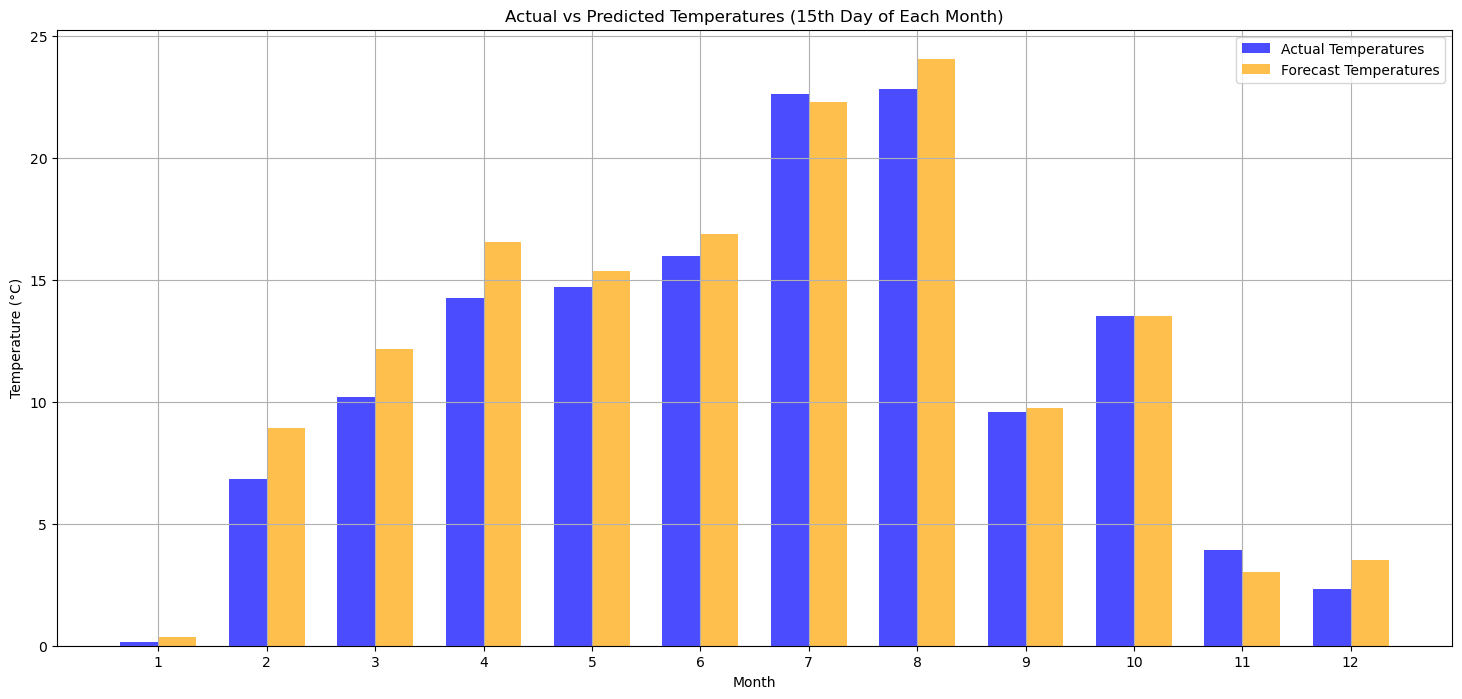

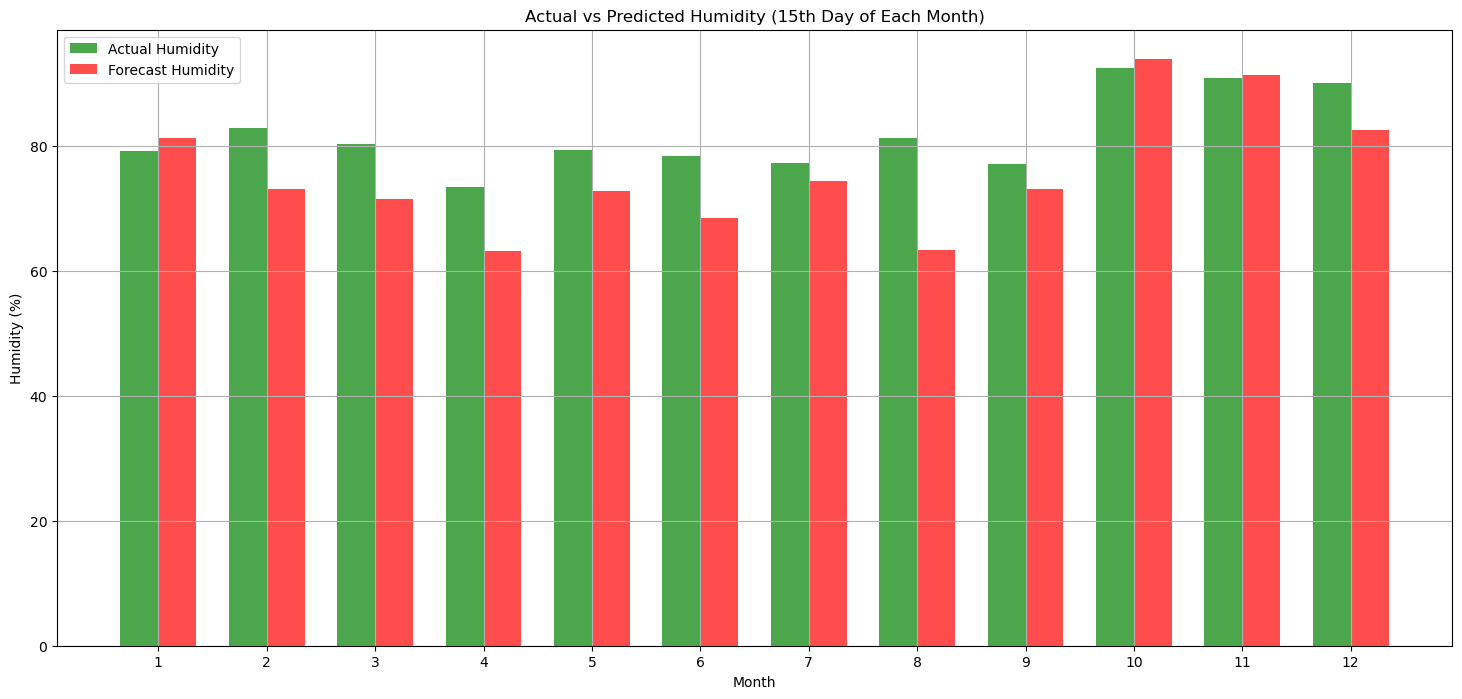

In [99]:
# Prepare data for the bar charts
if not merged_df.empty:
    monthly_data = merged_df.groupby(merged_df['datetime'].dt.month).agg(
        actual_temp=('temperature_2m_actual', 'mean'),
        forecast_temp=('temperature_2m_forecast', 'mean'),
        actual_humidity=('relative_humidity_2m_actual', 'mean'),
        forecast_humidity=('relative_humidity_2m_forecast', 'mean')
    )

    # Set the months on the X-axis
    months = np.arange(1, 13)

    # Set the width for the bars
    bar_width = 0.35

    # Set the X positions for the bars
    index = np.arange(len(months))

    # Bar chart for temperatures
    plt.figure(figsize=(18, 8))
    plt.bar(index - bar_width / 2, monthly_data['actual_temp'], bar_width, label='Actual Temperatures', color='blue', alpha=0.7)
    plt.bar(index + bar_width / 2, monthly_data['forecast_temp'], bar_width, label='Forecast Temperatures', color='orange', alpha=0.7)
    plt.title('Actual vs Predicted Temperatures (15th Day of Each Month)')
    plt.xlabel('Month')
    plt.ylabel('Temperature (°C)')
    plt.xticks(index, months)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Bar chart for humidity
    plt.figure(figsize=(18, 8))
    plt.bar(index - bar_width / 2, monthly_data['actual_humidity'], bar_width, label='Actual Humidity', color='green', alpha=0.7)
    plt.bar(index + bar_width / 2, monthly_data['forecast_humidity'], bar_width, label='Forecast Humidity', color='red', alpha=0.7)
    plt.title('Actual vs Predicted Humidity (15th Day of Each Month)')
    plt.xlabel('Month')
    plt.ylabel('Humidity (%)')
    plt.xticks(index, months)
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No data available for bar charts.")


# Cross-Validation

In [100]:
# Check if necessary columns are present
if {'temperature_2m_actual', 'temperature_2m_forecast', 'relative_humidity_2m_actual', 'relative_humidity_2m_forecast'}.issubset(merged_df.columns):
    # Define features and targets
    X = merged_df[['temperature_2m_forecast', 'relative_humidity_2m_forecast']]  # Use forecasted temperature and humidity as features
    y_temp = merged_df['temperature_2m_actual']  # Actual temperature as the first target
    y_humidity = merged_df['relative_humidity_2m_actual']  # Actual humidity as the second target

    # Check for missing values
    if X.isnull().sum().sum() > 0 or y_temp.isnull().sum() > 0 or y_humidity.isnull().sum() > 0:
        print("NaN values detected. Dropping missing values...")
        X = X.dropna()
        y_temp = y_temp.dropna()
        y_humidity = y_humidity.dropna()

    # Ensure there is enough data for cross-validation
    if len(X) < 5:
        print("Insufficient data for cross-validation with 5 splits.")
    else:
        # Initialize the Random Forest Regressor
        rf_model_temp = RandomForestRegressor(random_state=42)
        rf_model_humidity = RandomForestRegressor(random_state=42)

        # Define the KFold cross-validation setup
        kf = KFold(n_splits=5, random_state=42, shuffle=True)

        # Perform cross-validation for temperature
        cv_scores_temp = cross_val_score(rf_model_temp, X, y_temp, cv=kf, scoring='neg_mean_squared_error')

        # Perform cross-validation for humidity
        cv_scores_humidity = cross_val_score(rf_model_humidity, X, y_humidity, cv=kf, scoring='neg_mean_squared_error')

        # Check for NaN in the cross-validation scores
        if np.isnan(cv_scores_temp).any() or np.isnan(cv_scores_humidity).any():
            print("NaN detected in cross-validation scores. Check the data or model.")
        else:
            # Compute RMSE from the cross-validation scores
            rmse_temp = (-cv_scores_temp.mean()) ** 0.5
            rmse_humidity = (-cv_scores_humidity.mean()) ** 0.5
            print(f"Cross-validated RMSE (Temperature): {rmse_temp:.2f}")
            print(f"Cross-validated RMSE (Humidity): {rmse_humidity:.2f}")
else:
    print("Cross-validation could not be performed. Ensure the required columns are present in the dataset.")


Cross-validated RMSE (Temperature): 1.62
Cross-validated RMSE (Humidity): 8.04


# Interpretation



Temperature Forecast Accuracy:

The temperature predictions are highly accurate with RMSE = 1.88°C, MAE = 1.46°C, and R² = 0.94.
Seasonal trends (e.g., summer and winter) are well captured, with close alignment between actual and predicted temperatures, especially in stable months like July and August.
Slight discrepancies occur during transitional months (e.g., March and October), likely due to rapid weather changes.


Humidity Forecast Accuracy:

Humidity predictions are less accurate compared to temperature, with RMSE = 11.26%, MAE = 8.58%, and R² = 0.36.
Larger deviations between actual and forecasted humidity values are observed, particularly in winter and fall months.
This suggests room for improvement in modeling humidity, as it may involve more complex dynamics.

ANOVA Results:

Significant differences across months were identified for both actual and forecasted temperatures and humidity (p-value < 0.0001), confirming strong seasonal variability.
The model effectively captures these seasonal differences for temperature, while humidity shows greater variability and less alignment.


Cross-Validation:

Cross-validation for temperature predictions shows a strong performance with a cross-validated RMSE of 1.62°C.
For humidity, the cross-validated RMSE is 8.04%, reinforcing that the humidity model has more room for improvement.
